In [1]:
import sys

In [2]:
sys.path.append('..')

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import arviz as az
import pymc3 as pm
from helpers import CausalModel, lfilter, create_standardizer_destandardizer
from copy import deepcopy
import seaborn as sns

In [4]:
%matplotlib Inline

In [5]:
%config InlineBackend.figure_format = 'svg'

In [6]:
np.set_printoptions(formatter={float: lambda x: '{:,.3f}'.format(x)})
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

# The Haunted DAG & The Causal Terror

## Practice

### 6E1. 
List three mechanisms by which multiple regression can produce false inferences about causal effects.

1. Multicollinearity
2. Post-treatment Bias
3. Collider Bias

### 6E2. 
For one of the mechanisms in the previous problem, provide an example of your choice, perhaps from your own research.

Covid studies using only hospitalized patients data to causal inference

### 6E3.
List the four elemental confounds. Can you explain the conditional dependencies of each?

The fork, the collider, the pipe, and the descendant.

1. **The Fork** |  X <- Z -> Y

In a fork, Z is the common cause of X and Y. This common cause creates a correlation between X and Y. 
If we condition on Z (or in another words, put Z onto the regression), then learning X tell us nothing about Y. X and Y are independent, conditional on Z.

---

2. **The Pipe** | X -> Z -> Y

Conditional on Z, X and Y are independent. So to break the flow of information between X and Y you must add Z to your regression

---

3. **The Collider** | X -> Z <- Y

Unlike the previous ones, there is no association between X and Y unless you condition on Z. So to break the flow of information between X and Y you must remove Z from your regression.

---

4. **The Descendent** | 

Conditioning on D will also (partly) condition on Z, because D (as a child of Z) contains information about Z. Conditioning on D will also open the flow of information between X and Y because they are a collider on Z

### 6E4.
How is a biased sample like conditioning on a collider? Think of the example at the open of the chapter.

The DAG:

- T: Trustworthiness
- S: Selected
- N: Newsworthiness

T -> S <- N

Trustworthiness influences selection and Newsworthiness also influences selection. So when you condition on selection, it will appear as T influences N or N influences T. To break the flow of information between then you must remove S from your model. Or in the case of sampling, you should not only use the selected as a sample

### 6M1. 

Modify the DAG on page 186 to include the variable V, an unobserved cause of C and Y: C ← V → Y. Reanalyze the DAG. How many paths connect X to Y? Which must be closed? Which variables should you condition on now?

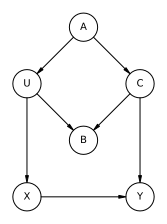

In [7]:
original_dag = CausalModel(
    nodes=['X', 'Y', 'A', 'C', 'U', 'B'],
    edges=[
        ('X', 'Y'),
        ('U', 'X'),
        ('A', 'U'),
        ('A', 'C'),
        ('C', 'Y'),
        ('U', 'B'),
        ('C', 'B'),
    ]
)

original_dag.draw_coords({
    "A": (1, 0),
    "U": (0, 1),
    "C": (2, 1),
    "B": (1, 2),
    "X": (0, 3),
    "Y": (2, 3),
})

In [8]:
original_dag.get_all_backdoor_paths('X', 'Y')

[['X', 'U', 'A', 'C', 'Y'], ['X', 'U', 'B', 'C', 'Y']]

In [9]:
original_dag.get_adjustment_sets('X', 'Y', disregard=['U'])

[frozenset({'C'}), frozenset({'A'})]

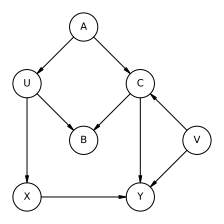

In [10]:
new_dag = CausalModel(
    nodes=['X', 'Y', 'A', 'C', 'U', 'B', 'V'],
    edges=[
        ('X', 'Y'),
        ('U', 'X'),
        ('A', 'U'),
        ('A', 'C'),
        ('C', 'Y'),
        ('U', 'B'),
        ('C', 'B'),
        ('V', 'C'),
        ('V', 'Y'),
    ]
)

new_dag.draw_coords({
    "A": (1, 0),
    "U": (0, 1),
    "C": (2, 1),
    "B": (1, 2),
    "X": (0, 3),
    "Y": (2, 3),
    "V": (3, 2),
})

In [11]:
new_dag.get_all_backdoor_paths('X', 'Y')

[['X', 'U', 'A', 'C', 'Y'],
 ['X', 'U', 'A', 'C', 'V', 'Y'],
 ['X', 'U', 'B', 'C', 'Y'],
 ['X', 'U', 'B', 'C', 'V', 'Y']]

In [12]:
new_dag.get_adjustment_sets('X', 'Y', disregard=['U'])

[frozenset({'A'}), frozenset({'C', 'V'})]

### 6M2. 

Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among predictors before including them in a model. This is a bad procedure, because what matters is the conditional association, not the association before the variables are included in the model. To highlight this, consider the DAG X → Z → Y. Simulate data from this DAG so that the correlation between X and Z is very large. Then include both in a model prediction Y. Do you observe any multicollinearity? Why or why not? What is different from the legs example in the chapter?

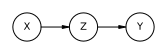

In [13]:
dag = CausalModel(
    nodes=['X', 'Y', 'Z'],
    edges=[
        ('X', 'Z'),
        ('Z', 'Y'),
    ]
)

dag.draw_coords({"X": (0, 0), "Z": (1, 0), "Y": (2, 0)})

In [14]:
dag.get_all_backdoor_paths('X', 'Y')

[]

In [15]:
dag.get_adjustment_sets('X', 'Y')

[frozenset()]

In [16]:
X = stats.norm().rvs(1000)
Z = stats.norm(X*1.2).rvs()
Y = stats.norm(Z*1.4).rvs()

df = pd.DataFrame({"X": X, "Z": Z, "Y": Y})
df.head()

,X,Z,Y
0,-0.593,0.949,1.738
1,0.904,1.196,1.163
2,-0.642,1.064,1.136
3,-0.022,-0.222,-0.228
4,-0.093,0.555,1.600


In [17]:
df.corr()

,X,Z,Y
X,1.000,0.751,0.677
Z,0.751,1.000,0.900
Y,0.677,0.900,1.000


In [18]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(
        formula='Y ~ X + Z',
        data=df,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    trace = pm.sample()

<ipython-input-18-a8cf3554f6e2>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Z, X, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


In [19]:
az.summary(trace, hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,-0.022,0.032,-0.071,0.029
X,0.016,0.049,-0.065,0.091
Z,1.326,0.032,1.277,1.378
sd,1.002,0.023,0.964,1.039


We don't observe multicollinearity in this case. Because in this case one variable is clearly more important than another. On the legs case you had this DAG:

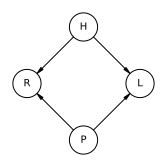

In [20]:
dag = CausalModel(
    nodes=['L', 'R', 'P', 'H'],
    edges=[
        ('P', 'L'),
        ('P', 'R'),
        ('H', 'L'),
        ('H', 'R')
    ]
)

dag.draw_coords({"H": (1, 0), "P": (1, 2), "R": (0, 1), "L": (2, 1)})

Height influences the left leg size and the right leg size equally. So when you used both in the regression you had multicollinearity

### 6M3.
Learning to analyze DAGs requires practice. For each of the four DAGs below, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of X on Y.

#### Dag 1 - Top Left

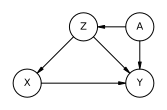

In [21]:
dag = CausalModel(
    nodes=['A', 'Z', 'X', 'Y'],
    edges=[
        ('A', 'Z'),
        ('A', 'Y'),
        ('Z', 'X'),
        ('Z', 'Y'),
        ('X', 'Y'),
    ]
)

dag.draw_coords({
    "A": (2, 0),
    "Z": (1, 0),
    "X": (0, 1),
    "Y": (2, 1)
})

In [22]:
dag.get_all_backdoor_paths('X', 'Y')

[['X', 'Z', 'A', 'Y'], ['X', 'Z', 'Y']]

In [23]:
dag.get_adjustment_sets("X", "Y")

[frozenset({'Z'})]

#### Dag 2 - Top Right

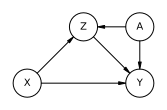

In [24]:
dag = CausalModel(
    nodes=['A', 'Z', 'X', 'Y'],
    edges=[
        ('A', 'Z'),
        ('A', 'Y'),
        ('X', 'Z'),
        ('Z', 'Y'),
        ('X', 'Y'),
    ]
)

dag.draw_coords({
    "A": (2, 0),
    "Z": (1, 0),
    "X": (0, 1),
    "Y": (2, 1)
})

In [25]:
dag.get_all_backdoor_paths('X', 'Y'), dag.get_adjustment_sets("X", "Y")

([], [frozenset()])

#### Dag 3 - Bottom Left

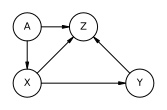

In [26]:
dag = CausalModel(
    nodes=['A', 'Z', 'X', 'Y'],
    edges=[
        ('A', 'X'),
        ('A', 'Z'),
        ('X', 'Z'),
        ('X', 'Y'),
        ('Y', 'Z'),
    ]
)

dag.draw_coords({
    "A": (0, 0),
    "Z": (1, 0),
    "X": (0, 1),
    "Y": (2, 1),
})

In [27]:
dag.get_all_backdoor_paths("X", "Y")

[['X', 'A', 'Z', 'Y']]

In [28]:
dag.get_adjustment_sets("X", "Y")

[frozenset()]

### Dag 4 - Bottom Right

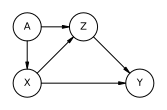

In [29]:
dag = CausalModel(
    nodes=['A', 'Z', 'X', 'Y'],
    edges=[
        ('A', 'X'),
        ('A', 'Z'),
        ('X', 'Z'),
        ('X', 'Y'),
        ('Z', 'Y'),
    ]
)

dag.draw_coords({
    "A": (0, 0),
    "Z": (1, 0),
    "X": (0, 1),
    "Y": (2, 1),
})

In [30]:
dag.get_all_backdoor_paths("X", "Y")

[['X', 'A', 'Z', 'Y']]

In [31]:
dag.get_adjustment_sets("X", "Y")

[frozenset({'A'})]

### 6H1. 

Use the Waffle House data, data(WaffleDivorce), to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

### 6H2. 

Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data.

All three problems below are based on the same data. The data in data(foxes) are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own urban territory. Some territories are larger than others. The area variable encodes this information. Some territories also have more avgfood than others. We want to model the weight of each fox. For the problems below, assume the following DAG:

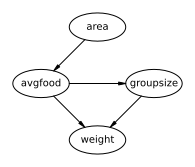

In [32]:
fox_dag = CausalModel(
    nodes=['area', 'avgfood', 'groupsize', 'weight'],
    edges=[
        ('area', 'avgfood'),
        ('avgfood', 'groupsize'),
        ('avgfood', 'weight'),
        ('groupsize', 'weight'),
    ]
)

fox_dag.draw_coords({
    "area": (1, 0),
    "avgfood": (0, 1),
    "groupsize": (2, 1),
    "weight": (1, 2)
}, aspect=2)

### 6H3. 

Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range.

### 6H4.

Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

### 6H5.

Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

### 6H6.
Consider your own research question. Draw a DAG to represent it. What are the testable implications of your DAG? Are there any variables you could condition on to close all backdoor paths? Are there unobserved variables that you have omitted? Would a reasonable colleague imagine additional threats to causal inference that you have ignored?

### 6H7.

For the DAG you made in the previous problem, can you write a data generating simulation for it? Can you design one or more statistical models to produce causal estimates? If so, try to calculate interesting counterfactuals. If not, use the simulation to estimate the size of the bias you might expect. Under what conditions would you, for example, infer the opposite of a true causal effect?